# Build NN

## 1. Prepare datasets

In [80]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [81]:
import random
import torch
import torchvision
from torchvision import transforms, datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
root='/content/drive/My Drive/Colab Notebooks/Data/MNIST'

In [82]:
train_val = datasets.MNIST(root, train=True, download=False,
                      transform=transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.ToTensor()
                        ]))
test = datasets.MNIST(root, train=False, download=False,
                      transform=transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.ToTensor()
                        ]))

In [83]:
lengths = [50000,10000]
train_btch_size=10
val_btch_size=10
tst_btch_size=10
generator = torch.Generator().manual_seed(3)
train,val = torch.utils.data.random_split(train_val,lengths,generator=generator)
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
valset = torch.utils.data.DataLoader(val, batch_size=10, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

## 2. Build simple neural network

Import torch.nn for building module.Import torch.nn.functional for funcitons we will use.

Question：
1. How many layers is better?
2. Parallel or Pyramid?
3. Why last layer don't have activate funciton?
4. What is log_softmax?

In [84]:
# 1024,512,10
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [85]:
# 1536,1024,512,10
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1536)
        self.fc2 = nn.Linear(1536, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 10)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [86]:
# 2048, 1536, 1024, 512,10
class Net5(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 2048)
        self.fc2 = nn.Linear(2048, 1536)
        self.fc3 = nn.Linear(1536, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 10)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

In [87]:
# 2560,2048,1536,1024,512,10
class Net6(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 2560)
        self.fc2 = nn.Linear(2560, 2048)
        self.fc3 = nn.Linear(2048, 1536)
        self.fc4 = nn.Linear(1536, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 10)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

## 3. Push random Input

Give random image size input to see the result.

In [88]:
# X = torch.rand((28,28))
# X = X.view(-1,28*28) #any size
# output = net(X)
# output

## 4. Optimizer

> net.parameters() -> What can be modified.<br/>
> lr -> Learning Rate

GPU


In [89]:
# networks: Net3, Net4, Net5, Net6
net = Net5()
use_gpu = torch.cuda.is_available()
if use_gpu:
  net.cuda()

# optimizer
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# epoch
EPOCHS = 30

# learning rate decrease (epoch>5)
# lr_lambda = lambda epoch: 1 if epoch<5 else 0.9**(epoch-5)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,0.9)
print('GPU:',use_gpu)
print(net)

GPU: True
Net5(
  (fc1): Linear(in_features=784, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1536, bias=True)
  (fc3): Linear(in_features=1536, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=10, bias=True)
)


In [90]:
%%time
random.seed(3)
torch.manual_seed(3)

losses = {'train':[],'val':[]}
corrects = {'train':[],'val':[]}

for epoch in range(EPOCHS):
  scheduler.step()
  trn_corr = 0
  val_corr = 0
  for batch, data in enumerate(trainset):
      # data is a batch of featuresets and labels
      # batch stands for batch number
      batch+=1
      X, y = data
      if use_gpu:
        X = Variable(X).cuda()
        y = Variable(y).cuda()
      net.zero_grad()
      output = net(X.view(-1,28*28))
      loss = F.nll_loss(output,y)
      predicted =torch.max(output.data,1)[1]
      trn_corr+=(predicted == y).sum()
      loss.backward()
      optimizer.step() # adjust data

      if batch%100 ==0:
            print(f'epoch:{epoch} batch:{batch} loss:{loss.item()} accuracy:{trn_corr.item()/(batch*train_btch_size)*100}')

  losses['train'].append(loss.item())
  corrects['train'].append(trn_corr.item()*100/(batch*train_btch_size))

  with torch.no_grad():
    for batch_val, data_val in enumerate(valset):
      X_val,y_val = data_val
      if use_gpu:
        X_val = Variable(X_val).cuda()
        y_val = Variable(y_val).cuda()
      output_val = net(X_val.view(-1,28*28))
      predicted_val = torch.max(output_val.data,1)[1]
      val_corr +=(predicted_val==y_val).sum()

    loss = F.nll_loss(output_val,y_val)
    losses['val'].append(loss)
    corrects['val'].append(val_corr.item()/(batch_val*val_btch_size)*100)

  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch:0 batch:100 loss:0.4537931978702545 accuracy:46.6
epoch:0 batch:200 loss:1.4366567134857178 accuracy:57.45
epoch:0 batch:300 loss:0.57422935962677 accuracy:65.10000000000001
epoch:0 batch:400 loss:0.7282356023788452 accuracy:69.15
epoch:0 batch:500 loss:0.061248164623975754 accuracy:72.5
epoch:0 batch:600 loss:1.2039299011230469 accuracy:75.03333333333333
epoch:0 batch:700 loss:0.17228813469409943 accuracy:77.15714285714286
epoch:0 batch:800 loss:0.4305080473423004 accuracy:78.57499999999999
epoch:0 batch:900 loss:0.12596368789672852 accuracy:79.81111111111112
epoch:0 batch:1000 loss:0.13545674085617065 accuracy:80.92
epoch:0 batch:1100 loss:0.17626336216926575 accuracy:81.8
epoch:0 batch:1200 loss:0.08724461495876312 accuracy:82.35833333333333
epoch:0 batch:1300 loss:0.12086032330989838 accuracy:82.94615384615385
epoch:0 batch:1400 loss:0.07400397211313248 accuracy:83.42142857142856
epoch:0 batch:1500 loss:0.3957125246524811 accuracy:83.93333333333334
epoch:0 batch:1600 loss:0.0

## Plot training process
1. Plot train and val loss changes
2. Plot train and val accuracy changes

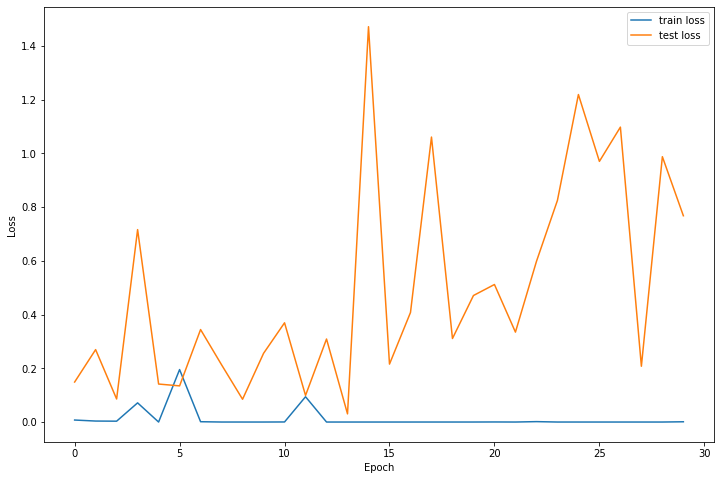

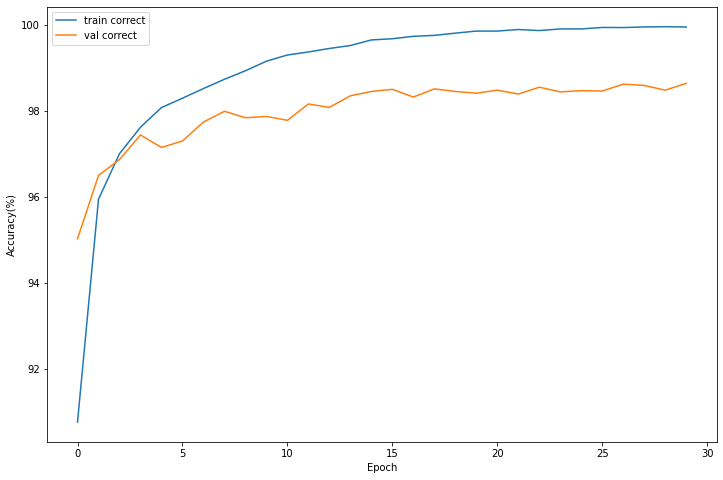

In [91]:
#  Plot train loss and val loss 
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses['train'],label = 'train loss')
plt.plot(losses['val'],label  = 'test loss')
plt.legend()

#  Plot train and val accuracy
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.plot(corrects['train'],label = 'train correct')
plt.plot(corrects['val'], label = 'val correct')
plt.legend()

In [92]:
print('train: ',max(corrects['train']))
print('val: ',max(corrects['val']))

train:  99.954
val:  98.63863863863864


## 5. Check Accuracy on Testset

In [96]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X,y = data
        if use_gpu:
          X = Variable(X).cuda()
          y = Variable(y).cuda()
        output = net(X.view(-1,784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Accuracy: ", round(correct/total, 4))

Accuracy:  0.9872


20 epochs

|id|architecture|best val err[%]|tst err[%]|training time|
|::|:----------:|:---------------:|:---------:|-------------:|
|1|1024,512,10|1.431|1.4|7min57s|
|2|1024,512,10*|1.441|1.4|7min50s|
|3|1536,1024,512,10|1.542|1.4|8min54s|
|4|2048,1536,1024,512,10|1.512|1.6|13min3s|
|5|2560,2048,1536,1024,512,10|||||

* 2 change the learning rate decrease stratgy, from LambdaLR to ExponentialLR.

30 epochs

|id|architecture|best val err[%]|tst err[%]|training time|
|::|:----------:|:---------------:|:---------:|-------------:|
|1|1024,512,10|1.351|1.39|11min53s|
|2|1536,1024,512,10*|1.331|1.38|8min46s|
|3|2048,1536,1024,512,10|1.361|1.28|19min35s|
|4|2560,2048,1536,1024,512,10|1.281|1.32|10min52s|

* 2 was trained on different GPU resource. The system time is also different.

This will cause several variants exist in model testing environment and they will make distroy the reproducibity of this experiment.

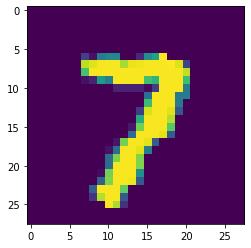

In [94]:
plt.imshow(X[0].cpu().view(28,28))
plt.show()

In [95]:
print(torch.argmax(net(X[0].view(-1,784))[0]))

tensor(7, device='cuda:0')
